# Integrantes
- Daniel Diab
- Laura Martinez

# 1. Preparación Datos
## 1.1. Importar Librerias

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

## 1.2. Cargar Datos

In [3]:
df = pd.read_csv('./data.csv', sep=',', header=0)
datos = df.copy()

## 1.3. Eliminar Duplicados

In [5]:
import pandas as pd

def corregir_fechas(df, col="Date of Service"):
    df = df.copy()

    s = df[col].astype("string").str.strip()
    s = s.replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA, "null": pd.NA, "None": pd.NA})

    # pandas moderno: resuelve formatos mixtos de forma fiable
    try:
        dt = pd.to_datetime(s, errors="coerce", format="mixed", dayfirst=True)
    except TypeError:
        dt = pd.to_datetime(s, errors="coerce", dayfirst=True)
        m = dt.isna() & s.notna()
        dt.loc[m] = pd.to_datetime(s[m], errors="coerce", dayfirst=False)

    df[col] = dt.dt.normalize() #solo fecha, no hora
    return df

datos = corregir_fechas(datos, "Date of Service")
print("Fechas inválidas:", datos["Date of Service"].isna().sum())

Fechas inválidas: 0


In [6]:
print("Duplicados exactos:", datos.duplicated().sum())

Duplicados exactos: 151


In [7]:
datos = datos.drop_duplicates()
datos.shape

(1488, 24)

In [8]:
cols_llave = ["Patient ID", "Date of Service"]

conflict_keys = datos.loc[
    datos.duplicated(subset=cols_llave, keep=False), cols_llave].drop_duplicates()

print("Llaves conflictivas:", len(conflict_keys))

datos = datos.merge(conflict_keys, on=cols_llave, how="left", indicator=True)
datos = datos[datos["_merge"] == "left_only"].drop(columns="_merge")

print("Filas restantes:", len(datos))

Llaves conflictivas: 112
Filas restantes: 1264


In [9]:
# Variable objetivo
target = "CVD Risk Score"

print("Filas antes de eliminar NaN en target:", len(datos))
print("NaN en target:", datos[target].isna().sum())

# Eliminar filas sin variable objetivo
datos = datos.dropna(subset=[target]).copy()

print("Filas después de eliminar NaN en target:", len(datos))
print("NaN en target ahora:", datos[target].isna().sum())

Filas antes de eliminar NaN en target: 1264
NaN en target: 27
Filas después de eliminar NaN en target: 1237
NaN en target ahora: 0


## 1.4. Separar Dataset

In [10]:
from sklearn.model_selection import train_test_split

X = datos.drop(columns=["CVD Risk Score", "CVD Risk Level"], errors="ignore")
y = datos["CVD Risk Score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## 1.5. Pipeline

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer

In [12]:
cols_to_drop = ["Patient ID", "Date of Service", "CVD Risk Level", "Blood Pressure (mmgHg)"]

def drop_columns(df):
    return df.drop(columns=cols_to_drop, errors="ignore")

dropper = FunctionTransformer(drop_columns)

In [13]:
def _to_num(s):
    return pd.to_numeric(s, errors="coerce")

def completar_bp_desde_texto(df, col_bp_texto="Blood Pressure (mmHg)", col_sis="Systolic BP", col_dia="Diastolic BP"):
    df = df.copy()
    if col_bp_texto not in df.columns:
        return df

    s = df[col_bp_texto].astype("string").str.strip()
    extra = s.str.extract(r"^\s*(\d+)\s*/\s*(\d+)\s*$")
    sys = _to_num(extra[0])
    dia = _to_num(extra[1])

    if col_sis in df.columns:
        m = df[col_sis].isna() & sys.notna()
        df.loc[m, col_sis] = sys.loc[m]

    if col_dia in df.columns:
        m = df[col_dia].isna() & dia.notna()
        df.loc[m, col_dia] = dia.loc[m]

    return df

tr_completar_bp = FunctionTransformer(completar_bp_desde_texto)


def corregir_swap_bp(df, col_sis="Systolic BP", col_dia="Diastolic BP"):
    df = df.copy()
    if col_sis not in df.columns or col_dia not in df.columns:
        return df

    sis = _to_num(df[col_sis])
    dia = _to_num(df[col_dia])

    m = sis.notna() & dia.notna() & (dia > sis)
    if m.any():
        df.loc[m, col_sis], df.loc[m, col_dia] = dia.loc[m].values, sis.loc[m].values

    return df

tr_swap_bp = FunctionTransformer(corregir_swap_bp)


def completar_altura_m_cm(df, col_h_m="Height (m)", col_h_cm="Height (cm)"):
    df = df.copy()
    if col_h_m not in df.columns or col_h_cm not in df.columns:
        return df

    hm = _to_num(df[col_h_m])
    hcm = _to_num(df[col_h_cm])

    # si falta cm y hay m
    m1 = hm.notna() & hcm.isna()
    df.loc[m1, col_h_cm] = hm.loc[m1] * 100

    # si falta m y hay cm
    m2 = hm.isna() & hcm.notna()
    df.loc[m2, col_h_m] = hcm.loc[m2] / 100

    return df

tr_altura_completar = FunctionTransformer(completar_altura_m_cm)


def resolver_inconsistencia_altura(df, col_h_m="Height (m)", col_h_cm="Height (cm)", tol_cm=1.0):
    df = df.copy()
    if col_h_m not in df.columns or col_h_cm not in df.columns:
        return df

    hm = _to_num(df[col_h_m])
    hcm = _to_num(df[col_h_cm])

    m = hm.notna() & hcm.notna() & (abs(hcm - hm * 100) > tol_cm)
    if m.any():
        df.loc[m, col_h_cm] = hm.loc[m] * 100

    return df

tr_altura_resolver = FunctionTransformer(resolver_inconsistencia_altura)


def recalcular_bmi(df, col_peso="Weight", col_h_m="Height (m)", col_bmi="BMI"):
    df = df.copy()
    if col_peso not in df.columns or col_h_m not in df.columns or col_bmi not in df.columns:
        return df

    w = _to_num(df[col_peso])
    hm = _to_num(df[col_h_m])

    m = w.notna() & hm.notna() & (hm > 0)
    df.loc[m, col_bmi] = w.loc[m] / (hm.loc[m] ** 2)

    return df

tr_bmi = FunctionTransformer(recalcular_bmi)


def recalcular_waist_height_ratio(df, col_cintura="Abdominal Circumference (cm)", col_h_cm="Height (cm)", col_ratio="Waist-to-Height Ratio"):
    df = df.copy()
    if col_cintura not in df.columns or col_h_cm not in df.columns or col_ratio not in df.columns:
        return df

    cintura = _to_num(df[col_cintura])
    hcm = _to_num(df[col_h_cm])

    m = cintura.notna() & hcm.notna() & (hcm > 0)
    df.loc[m, col_ratio] = cintura.loc[m] / hcm.loc[m]

    return df

tr_ratio = FunctionTransformer(recalcular_waist_height_ratio)

def clip_iqr_array(X, factor=1.5):
    X = np.asarray(X, dtype=float)

    q1 = np.nanpercentile(X, 25, axis=0)
    q3 = np.nanpercentile(X, 75, axis=0)
    iqr = q3 - q1

    lower = q1 - factor * iqr
    upper = q3 + factor * iqr

    return np.clip(X, lower, upper)

clipper_transformer = FunctionTransformer(clip_iqr_array)

In [14]:
numeric_features = [
    "Age",
    "Weight (kg)",
    "Height (m)",
    "Height (cm)",
    "BMI",
    "Abdominal Circumference (cm)",
    "Waist-to-Height Ratio",
    "Systolic BP",
    "Diastolic BP",
    "Total Cholesterol (mg/dL)",
    "HDL (mg/dL)",
    "Estimated LDL (mg/dL)",
    "Fasting Blood Sugar (mg/dL)",
]

#Variables categóricas
binary_features = [
    "Sex",
    "Smoking Status",
    "Diabetes Status",
    "Family History of CVD",
]

ordinal_features = [
    "Physical Activity Level",
]

nominal_features = [
    "Blood Pressure Category",
]

In [15]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("clipper", clipper_transformer),
    ("scaler", StandardScaler()),
])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="if_binary", handle_unknown="ignore")),
])

ordinal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[["Low", "Moderate", "High"]])),
])

nominal_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

In [16]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("bin", binary_transformer, binary_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("nom", nominal_transformer, nominal_features),
    ],
    remainder="drop"
)

In [17]:
from sklearn.pipeline import Pipeline

pipeline_preparacion = Pipeline(steps=[
    ("bp_fill", tr_completar_bp),
    ("dropper", dropper),

    # determinísticas (en el orden correcto)
    ("bp_swap", tr_swap_bp),
    ("h_fill", tr_altura_completar),
    ("h_fix", tr_altura_resolver),
    ("bmi", tr_bmi),
    ("ratio", tr_ratio),

    # no determinísticas (aprenden en fit): imputación + clipping + escalado + encoding
    ("preprocesamiento", preprocessor),
])

pipeline_preparacion

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('bp_fill', ...), ('dropper', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function com...001ECB7F55B10>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments to pas

In [18]:
from sklearn.linear_model import LinearRegression

pipeline_regresion = Pipeline(steps=[
    ("preparacion", pipeline_preparacion),
    ("modelo", LinearRegression())
])

pipeline_regresion

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preparacion', ...), ('modelo', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('bp_fill', ...), ('dropper', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function com...001ECB7F55B10>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse t

In [19]:
pipeline_regresion.fit(X_train, y_train)

modelo = pipeline_regresion.named_steps["modelo"]
print("Número de coeficientes:", len(modelo.coef_))

Número de coeficientes: 22


In [20]:
y_train_pred = pipeline_regresion.predict(X_train)
y_test_pred  = pipeline_regresion.predict(X_test)

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def reporte_metricas(y_true, y_pred, nombre=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"--- {nombre} ---")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
    print()

reporte_metricas(y_train, y_train_pred, "Train")
reporte_metricas(y_test, y_test_pred, "Test")

--- Train ---
MAE:  3.1365
RMSE: 10.7059
R2:   0.0755

--- Test ---
MAE:  3.0179
RMSE: 10.2431
R2:   0.0124



In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(927, 22)
(927,)
(310, 22)
(310,)


## Polinomial
Con el fin de poder continunar con las actividades, empezaremos por construir un moedo polinomial.

In [23]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

Para poder comenzar realizaremos un nuevo pipeline para la polinomial, considerando que lo aplicamos es a las variables númericas, a las categoricas no tiene sentido ...

In [24]:
numeric_transform_polinomial = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("clipper", clipper_transformer),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
])

preprocessor_polinomial = ColumnTransformer(
    transformers=[
        ("num", numeric_transform_polinomial, numeric_features),
        ("bin", binary_transformer, binary_features),
        ("ord", ordinal_transformer, ordinal_features),
        ("nom", nominal_transformer, nominal_features),
    ],
    remainder="drop"
)

pipeline_polinomial = Pipeline(steps=[
    ("bp_fill", tr_completar_bp),
    ("dropper", dropper),

    # determinísticas (en el orden correcto)
    ("bp_swap", tr_swap_bp),
    ("h_fill", tr_altura_completar),
    ("h_fix", tr_altura_resolver),
    ("bmi", tr_bmi),
    ("ratio", tr_ratio),

    # no determinísticas (aprenden en fit): imputación + clipping + escalado + encoding
    ("preprocesamiento", preprocessor_polinomial),
    ("modelo", LinearRegression())
])

Para evaluar cómo influye la complejidad del modelo en su desempeño, se realizará una búsqueda del grado del polinomio utilizando GridSearchCV con validación cruzada.

El grado controla la flexibilidad del modelo: valores bajos generan modelos más simples, mientras que valores altos permiten capturar relaciones más complejas.

Mediante validación cruzada se seleccionará automáticamente el grado que obtenga mejor desempeño promedio en términos de RMSE, evitando elegirlo de forma arbitraria.

In [30]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import KFold

param_grid = {
    "preprocesamiento__num__poly__degree": [1,2,3,4],
    "preprocesamiento__num__scaler": [
        StandardScaler(),
        RobustScaler(),
        MinMaxScaler(),
        MaxAbsScaler(),
        PowerTransformer(method="yeo-johnson"),
        QuantileTransformer(output_distribution="normal"),
        QuantileTransformer(output_distribution="uniform"),
        "passthrough"
    ]
}

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

grid = GridSearchCV(
    estimator=pipeline_polinomial,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True, random_state=42), #kfold cross validation con 5 folds
    scoring=scoring, #como se maximiza, y el error queremos es el mínimo, pues se pone negativo
    refit="rmse",
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

grid.fit(X_train, y_train)

print("Mejor configuración:", grid.best_params_)
print("Mejor RMSE CV (neg):", -grid.best_score_)

# --- Tabla con resultados CV por combinación ---
res = pd.DataFrame(grid.cv_results_)

def scaler_name(x):
    if x == "passthrough":
        return "passthrough"
    return x.__class__.__name__

tabla = pd.DataFrame({
    "degree": res["param_preprocesamiento__num__poly__degree"].astype(int),
    "scaler": res["param_preprocesamiento__num__scaler"].apply(scaler_name),

    # CV (test) mean/std
    "RMSE_CV_mean": -res["mean_test_rmse"],
    "RMSE_CV_std":  res["std_test_rmse"],

    "MAE_CV_mean":  -res["mean_test_mae"],
    "MAE_CV_std":   res["std_test_mae"],

    "R2_CV_mean":    res["mean_test_r2"],
    "R2_CV_std":     res["std_test_r2"],

    # (opcional) Train CV mean/std (promedios de folds en train)
    "RMSE_train_mean": -res["mean_train_rmse"],
    "MAE_train_mean":  -res["mean_train_mae"],
    "R2_train_mean":    res["mean_train_r2"],
})

tabla = tabla.sort_values(["RMSE_CV_mean", "MAE_CV_mean"], ascending=[True, True]).reset_index(drop=True)

display(tabla.head(20))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejor configuración: {'preprocesamiento__num__poly__degree': 1, 'preprocesamiento__num__scaler': QuantileTransformer(output_distribution='normal')}
Mejor RMSE CV (neg): 10.864762016020341


c:\Users\Admin\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\sklearn\preprocessing\_data.py:2885: UserWarning: n_quantiles (1000) is greater than the total number of samples (927). n_quantiles is set to n_samples.
  warnings.warn(


,degree,scaler,RMSE_CV_mean,RMSE_CV_std,MAE_CV_mean,MAE_CV_std,R2_CV_mean,R2_CV_std,RMSE_train_mean,MAE_train_mean,R2_train_mean
0,1,QuantileTransformer,10.864762,1.649315,3.418810,0.184179,0.017911,0.038840,1.066545e+01,3.305306e+00,0.081397
1,1,MinMaxScaler,10.864989,1.646868,3.342679,0.182908,0.017659,0.040671,1.066821e+01,3.223985e+00,0.080945
2,1,RobustScaler,10.864989,1.646868,3.342679,0.182908,0.017659,0.040671,1.066821e+01,3.223985e+00,0.080945
3,1,StandardScaler,10.864989,1.646868,3.342679,0.182908,0.017659,0.040671,1.066821e+01,3.223985e+00,0.080945
4,1,MaxAbsScaler,10.864989,1.646868,3.342679,0.182908,0.017659,0.040671,1.066821e+01,3.223985e+00,0.080945
5,1,passthrough,10.864989,1.646868,3.342679,0.182908,0.017659,0.040671,1.066821e+01,3.223985e+00,0.080945
6,1,QuantileTransformer,10.866548,1.667316,3.354814,0.191542,0.018590,0.030535,1.065385e+01,3.247803e+00,0.083465
7,1,PowerTransformer,10.873160,1.660247,3.395894,0.205607,0.016490,0.042174,1.066419e+01,3.258527e+00,0.081652
8,2,QuantileTransformer,11.362281,1.503756,4.861519,0.327074,-0.085397,0.101393,9.989590e+00,4.292531e+00,0.194052
9,2,PowerTransformer,12.338692,1.105965,5.131396,0.240137,-0.318878,0.304159,9.926151e+00,4.044880e+00,0.203975


In [31]:
mejor_modelo = grid.best_estimator_

y_pred_train = mejor_modelo.predict(X_train)
y_pred_test  = mejor_modelo.predict(X_test)

def metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

rmse_tr, mae_tr, r2_tr = metricas(y_train, y_pred_train)
rmse_te, mae_te, r2_te = metricas(y_test, y_pred_test)

print("\n--- Mejor modelo ---")
print("TRAIN  | RMSE:", rmse_tr, "| MAE:", mae_tr, "| R2:", r2_tr)
print("TEST   | RMSE:", rmse_te, "| MAE:", mae_te, "| R2:", r2_te)


--- Mejor modelo ---
TRAIN  | RMSE: 10.692976295775674 | MAE: 3.2425568598355587 | R2: 0.07774455560618143
TEST   | RMSE: 10.23853416790113 | MAE: 3.1473453077124134 | R2: 0.0132428343207045


El mejor modelo encontrado corresponde a un polinomio de grado 1, lo que sugiere que incrementar la complejidad no mejora el desempeño bajo validación cruzada. Además, la cercanía entre los errores de entrenamiento y prueba indica ausencia de sobreajuste; sin embargo, el R² en prueba es muy bajo, lo cual sugiere limitada capacidad explicativa con las variables actuales.

## Curvas de validación

Con el fin de analizar cómo la complejidad del modelo afecta su desempeño, se generan curvas de validación en función del grado del polinomio.

Para cada grado, se calcula el error promedio en validación cruzada junto con su desviación estándar, lo que permite evaluar tanto el desempeño medio como la variabilidad del modelo.

Esto permite identificar el punto a partir del cual aumentar la complejidad comienza a producir sobreajuste, en términos del trade-off sesgo-varianza.

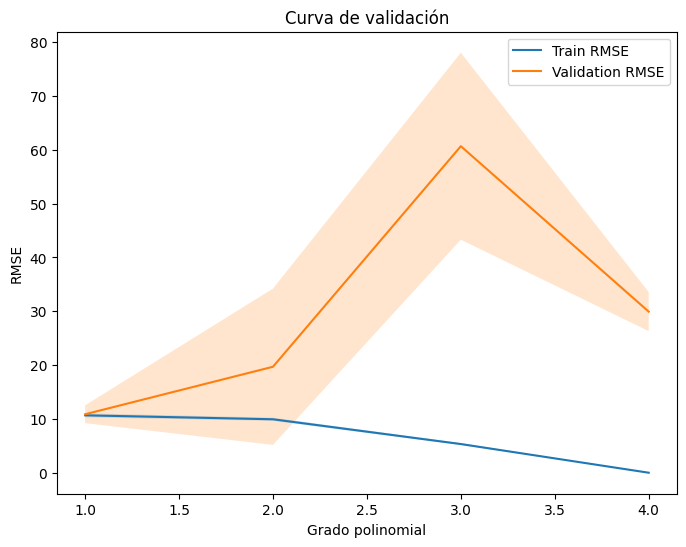

,grado,RMSE_train_mean,RMSE_train_std,RMSE_CV_mean,RMSE_CV_std,gap(CV-Train)
0,1,1.066545e+01,3.686990e-01,10.864762,1.649315,0.199308
1,2,9.930308e+00,2.958945e-01,19.688891,14.519124,9.758583
2,3,5.327572e+00,1.718146e-01,60.670428,17.367808,55.342857
3,4,4.893562e-13,2.591178e-13,29.929695,3.625561,29.929695


In [33]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import validation_curve

# 1) Fijar el mejor escalador encontrado por GridSearch (así solo varía el grado)
best_scaler = grid.best_params_["preprocesamiento__num__scaler"]

pipeline_para_curva = pipeline_polinomial.set_params(
    preprocesamiento__num__scaler=best_scaler
)

# 2) Rango de grados a evaluar
param_range = [1, 2, 3, 4]

# 3) validation_curve con RMSE (recuerda: sklearn lo devuelve NEGATIVO)
train_scores, val_scores = validation_curve(
    pipeline_para_curva,
    X_train,
    y_train,
    param_name="preprocesamiento__num__poly__degree",
    param_range=param_range,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

# 4) Convertir a RMSE positivo
train_rmse = -train_scores
val_rmse   = -val_scores

train_mean = train_rmse.mean(axis=1)
train_std  = train_rmse.std(axis=1)

val_mean   = val_rmse.mean(axis=1)
val_std    = val_rmse.std(axis=1)

# 5) Graficar curvas + variabilidad (banda)
plt.figure(figsize=(8, 6))
plt.plot(param_range, train_mean, label="Train RMSE")
plt.plot(param_range, val_mean, label="Validation RMSE")

plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.xlabel("Grado polinomial")
plt.ylabel("RMSE")
plt.title("Curva de validación")
plt.legend()
plt.show()

# 6) Tabla de soporte para el informe
import pandas as pd

tabla_curva = pd.DataFrame({
    "grado": param_range,
    "RMSE_train_mean": train_mean,
    "RMSE_train_std": train_std,
    "RMSE_CV_mean": val_mean,
    "RMSE_CV_std": val_std,
    "gap(CV-Train)": val_mean - train_mean
})

display(tabla_curva)

Los resultados muestran que para grado 1 (modelo lineal), el RMSE en entrenamiento y validación es muy similar, con una diferencia mínima entre ambas curvas. Esto indica un modelo estable, con baja varianza y adecuada capacidad de generalización. Aunque el modelo es relativamente simple, logra un equilibrio apropiado entre ajuste y estabilidad.

Al aumentar el grado a 2, el error en entrenamiento disminuye ligeramente, pero el error en validación aumenta de forma considerable y presenta mayor variabilidad entre particiones. Esta divergencia entre ambas curvas constituye la primera evidencia de sobreajuste. El modelo comienza a capturar patrones específicos del conjunto de entrenamiento que no se generalizan adecuadamente.

Para grados 3 y 4, el fenómeno se intensifica. El error de entrenamiento disminuye drásticamente, llegando prácticamente a cero en grado 4, mientras que el error de validación se incrementa de manera significativa. La brecha entre ambas curvas crece de forma pronunciada, lo que evidencia un aumento marcado de la varianza. En estos grados, el modelo dispone de un espacio de hipótesis demasiado amplio y termina memorizando los datos de entrenamiento en lugar de aprender relaciones generales.

El comportamiento observado refleja claramente el dilema sesgo–varianza. A medida que aumenta el grado polinomial, crece la complejidad del modelo y se amplía el espacio de hipótesis. Esto reduce el sesgo, ya que el modelo puede ajustarse con mayor precisión a los datos de entrenamiento, pero incrementa la varianza, deteriorando la capacidad de generalización.

En este caso, el grado 1 ofrece el mejor balance entre sesgo y varianza. Los modelos de mayor grado presentan sesgo bajo pero varianza alta, lo que conduce a sobreajuste. Por tanto, incrementar la complejidad no mejora el desempeño predictivo en validación cruzada, sino que introduce inestabilidad y pérdida de capacidad de generalización.

En conclusión, el análisis de las curvas de validación permite identificar que el sobreajuste comienza a evidenciarse a partir del grado 2, y que el modelo lineal constituye la opción más adecuada.

## Modelos con Regularización

Se implementan modelos de regresión lineal con regularización L2 (Ridge) y L1 (Lasso) usando pipelines.  
La regularización introduce una penalización controlada por el hiperparámetro `alpha`, que busca reducir el sobreajuste y mejorar la generalización.  
Se comparan los modelos sin regularización, Ridge y Lasso usando GridSearchCV (validación cruzada), explorando distintos valores de `alpha` y estrategias de escalamiento.  
Además, se analiza el efecto de la penalización sobre la magnitud de los coeficientes y, en Lasso, qué variables son llevadas exactamente a cero (selección automática de características).

In [36]:
from sklearn.linear_model import Ridge, Lasso

def scaler_name(x):
    if x == "passthrough":
        return "passthrough"
    return x.__class__.__name__

def construir_tabla_resultados(grid, prefix="preprocesamiento__num__"):
    res = pd.DataFrame(grid.cv_results_)
    return (
        pd.DataFrame({
            "degree": res[f"param_{prefix}poly__degree"].astype(int),
            "scaler": res[f"param_{prefix}scaler"].apply(scaler_name),
            "alpha":  res["param_modelo__alpha"].astype(float),

            "RMSE_CV_mean": -res["mean_test_rmse"],
            "RMSE_CV_std":   res["std_test_rmse"],

            "MAE_CV_mean":  -res["mean_test_mae"],
            "MAE_CV_std":    res["std_test_mae"],

            "R2_CV_mean":    res["mean_test_r2"],
            "R2_CV_std":     res["std_test_r2"],

            "RMSE_train_mean": -res["mean_train_rmse"],
            "MAE_train_mean":  -res["mean_train_mae"],
            "R2_train_mean":    res["mean_train_r2"],
        })
        .sort_values(["RMSE_CV_mean", "MAE_CV_mean"], ascending=[True, True])
        .reset_index(drop=True)
    )

def metricas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2",
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

scalers = [
    StandardScaler(),
    RobustScaler(),
    MinMaxScaler(),
    MaxAbsScaler(),
    PowerTransformer(method="yeo-johnson"),
    QuantileTransformer(output_distribution="normal"),
    QuantileTransformer(output_distribution="uniform"),
    "passthrough",
]

# Grid de penalización (alpha)
alphas = np.logspace(-4, 3, 12)  # 1e-4 ... 1e3

### Modelo Ridge (Regularización L2)

Ridge agrega una penalización L2 controlada por `alpha`, que tiende a reducir la magnitud de los coeficientes y mejorar la generalización sin llevarlos exactamente a cero.  

Se busca el mejor `alpha` con GridSearchCV y se prueban tanto distintos grados de polinomio como distintas estrategias de escalamiento.

In [37]:
pipeline_ridge = Pipeline(steps=[
    ("bp_fill", tr_completar_bp),
    ("dropper", dropper),
    ("bp_swap", tr_swap_bp),
    ("h_fill", tr_altura_completar),
    ("h_fix", tr_altura_resolver),
    ("bmi", tr_bmi),
    ("ratio", tr_ratio),

    ("preprocesamiento", preprocessor_polinomial), 
    ("modelo", Ridge(random_state=42)),
])

param_grid_ridge = {
    "preprocesamiento__num__poly__degree": [1, 2, 3, 4],
    "preprocesamiento__num__scaler": scalers,
    "modelo__alpha": alphas,
}

grid_ridge = GridSearchCV(
    estimator=pipeline_ridge,
    param_grid=param_grid_ridge,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

grid_ridge.fit(X_train, y_train)

print("\n=== RIDGE ===")
print("Mejor configuración:", grid_ridge.best_params_)
print("Mejor RMSE CV:", -grid_ridge.best_score_)

tabla_ridge = construir_tabla_resultados(grid_ridge)
display(tabla_ridge.head(20))

mejor_ridge = grid_ridge.best_estimator_
y_pred_train_r = mejor_ridge.predict(X_train)
y_pred_test_r  = mejor_ridge.predict(X_test)

rmse_tr, mae_tr, r2_tr = metricas(y_train, y_pred_train_r)
rmse_te, mae_te, r2_te = metricas(y_test,  y_pred_test_r)

print("--- Mejor RIDGE ---")
print("TRAIN | RMSE:", rmse_tr, "| MAE:", mae_tr, "| R2:", r2_tr)
print("TEST  | RMSE:", rmse_te, "| MAE:", mae_te, "| R2:", r2_te)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits

=== RIDGE ===
Mejor configuración: {'modelo__alpha': np.float64(53.366992312063125), 'preprocesamiento__num__poly__degree': 2, 'preprocesamiento__num__scaler': MaxAbsScaler()}
Mejor RMSE CV: 10.779910585134402


,degree,scaler,alpha,RMSE_CV_mean,RMSE_CV_std,MAE_CV_mean,MAE_CV_std,R2_CV_mean,R2_CV_std,RMSE_train_mean,MAE_train_mean,R2_train_mean
0,2,MaxAbsScaler,53.366992,10.779911,1.731645,3.055973,0.189721,0.037308,0.020279,10.712822,2.989327,0.073255
1,2,MinMaxScaler,53.366992,10.780681,1.732051,3.057882,0.191957,0.037124,0.022101,10.703112,2.988154,0.074934
2,1,StandardScaler,231.012970,10.782092,1.783702,2.998191,0.241525,0.038795,0.024314,10.747144,2.948780,0.067337
3,1,QuantileTransformer,53.366992,10.782737,1.726071,3.099734,0.175756,0.036753,0.016753,10.743879,3.051087,0.067875
4,2,QuantileTransformer,231.012970,10.784119,1.792285,2.977914,0.229781,0.038863,0.022502,10.759460,2.938426,0.065209
5,1,RobustScaler,231.012970,10.784904,1.779422,3.014797,0.233903,0.038316,0.019926,10.779744,2.978595,0.061666
6,1,PowerTransformer,231.012970,10.785647,1.791151,3.017729,0.234324,0.038430,0.025281,10.745492,2.964519,0.067632
7,3,MaxAbsScaler,231.012970,10.785847,1.781314,2.986901,0.242221,0.038033,0.022605,10.746510,2.936584,0.067440
8,3,MinMaxScaler,231.012970,10.786152,1.782246,2.990426,0.240009,0.037989,0.023357,10.741271,2.939860,0.068350
9,1,RobustScaler,53.366992,10.786416,1.730842,3.085697,0.206069,0.035892,0.025368,10.694427,3.008514,0.076439


--- Mejor RIDGE ---
TRAIN | RMSE: 10.735860440684025 | MAE: 2.953636368153507 | R2: 0.07033231735433754
TEST  | RMSE: 10.149501911434518 | MAE: 2.758877851830947 | R2: 0.030329506799556594


En el caso de Ridge, la búsqueda de hiperparámetros seleccionó un modelo de grado 2 con una penalización relativamente alta (α ≈ 53). Esto es relevante porque indica que, al incorporar términos polinomiales (mayor complejidad), el modelo necesita una penalización fuerte para mantener estabilidad. En validación cruzada, el RMSE se mantiene alrededor de 10.7–10.8 y el R² promedio es bajo (≈ 0.03–0.04), con una desviación estándar reducida. Además, la diferencia entre el error de entrenamiento y el de validación es pequeña, lo que sugiere que no existe una brecha marcada de generalización.

Este comportamiento contrasta con el modelo polinomial sin regularización, donde al aumentar el grado el error de entrenamiento disminuía drásticamente mientras el de validación crecía, evidenciando alta varianza. Con Ridge, la penalización L2 reduce la magnitud de los coeficientes asociados a los términos polinomiales, evitando que el modelo “explote” en complejidad efectiva. En términos del trade-off sesgo–varianza, Ridge introduce algo más de sesgo pero reduce significativamente la varianza, logrando que un modelo de mayor grado (2) no incurra en sobreajuste severo.

Sin embargo, aunque la regularización controla el sobreajuste, no produce una mejora sustancial en capacidad predictiva. El R² sigue siendo bajo y el RMSE es muy similar al del modelo lineal regularizado. Esto sugiere que el problema no es simplemente de falta de complejidad, sino de limitada señal explicativa en los datos. En síntesis, Ridge sí permite incrementar la complejidad sin deteriorar la generalización, pero no convierte esa complejidad adicional en ganancias significativas de desempeño.

### Modelo Lasso
Lasso agrega una penalización L1 controlada por `alpha`. A diferencia de Ridge, Lasso puede llevar coeficientes exactamente a cero, funcionando como selección automática de características. Se busca el mejor `alpha` con GridSearchCV y se prueban distintas estrategias de escalamiento.

In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

scalers_small = [
    MaxAbsScaler(),
    MinMaxScaler(),
    StandardScaler(),
    RobustScaler(),
]
alphas_small = np.logspace(-4, 1, 10)

pipeline_lasso = Pipeline(steps=[
    ("bp_fill", tr_completar_bp),
    ("dropper", dropper),
    ("bp_swap", tr_swap_bp),
    ("h_fill", tr_altura_completar),
    ("h_fix", tr_altura_resolver),
    ("bmi", tr_bmi),
    ("ratio", tr_ratio),

    ("preprocesamiento", preprocessor_polinomial),
    ("modelo", Lasso(max_iter=20000, tol=1e-3, selection="random", random_state=42)),
])

param_grid_lasso = {
    "preprocesamiento__num__poly__degree": [1, 2, 3],
    "preprocesamiento__num__scaler": scalers_small,
    "modelo__alpha": alphas_small,
}

grid_lasso = GridSearchCV(
    estimator=pipeline_lasso,
    param_grid=param_grid_lasso,
    cv=cv,
    scoring=scoring,
    refit="rmse",
    n_jobs=-1,
    verbose=2,
    return_train_score=True,
)

grid_lasso.fit(X_train, y_train)

print("\n=== LASSO (Grid reducido) ===")
print("Mejor configuración:", grid_lasso.best_params_)
print("Mejor RMSE CV:", -grid_lasso.best_score_)

mejor_lasso = grid_lasso.best_estimator_
y_pred_train = mejor_lasso.predict(X_train)
y_pred_test  = mejor_lasso.predict(X_test)

rmse_tr, mae_tr, r2_tr = metricas(y_train, y_pred_train)
rmse_te, mae_te, r2_te = metricas(y_test,  y_pred_test)

print("--- Mejor LASSO ---")
print("TRAIN | RMSE:", rmse_tr, "| MAE:", mae_tr, "| R2:", r2_tr)
print("TEST  | RMSE:", rmse_te, "| MAE:", mae_te, "| R2:", r2_te)

Fitting 5 folds for each of 120 candidates, totalling 600 fits

=== LASSO (Grid reducido) ===
Mejor configuración: {'modelo__alpha': np.float64(0.21544346900318845), 'preprocesamiento__num__poly__degree': 1, 'preprocesamiento__num__scaler': RobustScaler()}
Mejor RMSE CV: 10.737287789921512
--- Mejor LASSO ---
TRAIN | RMSE: 10.78811809249306 | MAE: 2.928396832803698 | R2: 0.061259828138647276
TEST  | RMSE: 10.201550748309883 | MAE: 2.6302053128868486 | R2: 0.02035864658194053


In [44]:
tabla_lasso = construir_tabla_resultados(grid_lasso)
display(tabla_lasso.head(20))

,degree,scaler,alpha,RMSE_CV_mean,RMSE_CV_std,MAE_CV_mean,MAE_CV_std,R2_CV_mean,R2_CV_std,RMSE_train_mean,MAE_train_mean,R2_train_mean
0,1,RobustScaler,0.215443,10.737288,1.773015,2.991221,0.233095,0.046444,0.027395,10.754489,2.945383,0.066082
1,1,StandardScaler,0.215443,10.753810,1.768751,2.997241,0.238663,0.043164,0.028600,10.735786,2.932896,0.069314
2,1,MinMaxScaler,0.059948,10.759965,1.726319,3.132207,0.196912,0.040606,0.024674,10.724948,3.069449,0.071158
3,1,MaxAbsScaler,0.059948,10.763895,1.718667,3.150739,0.187321,0.039683,0.022246,10.738644,3.093759,0.068782
4,2,RobustScaler,0.215443,10.774721,1.773835,3.004395,0.237490,0.039558,0.027728,10.735716,2.938444,0.069299
5,2,StandardScaler,0.215443,10.779396,1.762661,3.008740,0.227508,0.038129,0.030095,10.718657,2.939511,0.072260
6,2,MinMaxScaler,0.059948,10.782842,1.722370,3.121864,0.196406,0.036263,0.024340,10.709292,3.045131,0.073850
7,2,MaxAbsScaler,0.059948,10.786048,1.720283,3.122813,0.191931,0.035594,0.024043,10.716024,3.049615,0.072689
8,2,MinMaxScaler,0.215443,10.791053,1.736383,3.185834,0.275782,0.035751,0.010659,10.839536,3.176024,0.051208
9,3,MinMaxScaler,0.059948,10.795073,1.707341,3.145746,0.189382,0.033378,0.026145,10.698979,3.058699,0.075625


En el caso de Lasso, la mejor configuración seleccionó grado 1 con α ≈ 0.21. Es decir, al combinar expansión polinomial con penalización L1, el modelo óptimo no incorporó términos de mayor grado. Esto es conceptualmente importante: Lasso no solo penaliza la magnitud de los coeficientes, sino que puede llevarlos exactamente a cero, realizando selección automática de características. El hecho de que el mejor modelo sea lineal indica que, bajo penalización L1, los términos polinomiales adicionales no aportan mejora estable y son descartados.

En validación cruzada, el RMSE es similar al de Ridge (≈ 10.7), pero el R² en test es ligeramente inferior. La brecha entre entrenamiento y test tampoco es grande, lo que indica que el modelo es estable y no presenta sobreajuste pronunciado. No obstante, a diferencia de Ridge, aquí la regularización no permitió sostener un modelo de mayor grado; más bien, redujo la complejidad efectiva al mantener solo términos lineales relevantes.

Desde el punto de vista del control del sobreajuste, Lasso actúa de manera más restrictiva que Ridge. En lugar de permitir mayor complejidad estabilizada, tiende a simplificar el modelo. Esto sugiere que, para este conjunto de datos, la complejidad polinomial adicional no es robusta y puede incluso introducir ruido que Lasso decide eliminar.


## Comparación
La regularización sí permite controlar el sobreajuste al incrementar la complejidad, especialmente en el caso de Ridge, donde fue posible utilizar grado 2 sin deterioro marcado en validación cruzada. Sin embargo, el aumento de complejidad no se traduce en mejoras relevantes de desempeño. En Lasso, el propio proceso de regularización evita que la complejidad crezca innecesariamente, seleccionando un modelo lineal como óptimo.

Por tanto, la evidencia empírica muestra que la regularización controla la varianza inducida por la expansión polinomial, pero también revela que mayor complejidad no implica necesariamente mejor generalización. En este problema, el límite del desempeño parece estar determinado más por la información contenida en las variables que por la flexibilidad del modelo.

## Modelo Final

In [46]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def metricas_basicas(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

def extraer_cv(gridsearch):
    """
    Extrae métricas CV del mejor modelo usando los aliases del scoring dict:
    mean_test_rmse, mean_test_mae, mean_test_r2, etc.
    """
    res = gridsearch.cv_results_
    i = gridsearch.best_index_

    # RMSE y MAE vienen como negativos (por usar 'neg_*')
    rmse_mean = -res["mean_test_rmse"][i]
    rmse_std  =  res["std_test_rmse"][i]

    mae_mean  = -res["mean_test_mae"][i]
    mae_std   =  res["std_test_mae"][i]

    r2_mean   =  res["mean_test_r2"][i]
    r2_std    =  res["std_test_r2"][i]

    return rmse_mean, rmse_std, mae_mean, mae_std, r2_mean, r2_std

def resumen_modelo(nombre, gridsearch, X_train, X_test, y_train, y_test):
    best_model = gridsearch.best_estimator_

    # train/test
    y_tr_pred = best_model.predict(X_train)
    y_te_pred = best_model.predict(X_test)

    rmse_tr, mae_tr, r2_tr = metricas_basicas(y_train, y_tr_pred)
    rmse_te, mae_te, r2_te = metricas_basicas(y_test,  y_te_pred)

    # cv (del mejor)
    rmse_cv_mean, rmse_cv_std, mae_cv_mean, mae_cv_std, r2_cv_mean, r2_cv_std = extraer_cv(gridsearch)

    # hiperparámetros (para reportar claro)
    params = gridsearch.best_params_
    degree = params.get("preprocesamiento__num__poly__degree", None)
    scaler = params.get("preprocesamiento__num__scaler", None)
    alpha  = params.get("modelo__alpha", None)

    def scaler_name(s):
        if s is None:
            return None
        if s == "passthrough":
            return "passthrough"
        return s.__class__.__name__

    return {
        "Modelo": nombre,
        "degree": degree,
        "scaler": scaler_name(scaler),
        "alpha": float(alpha) if alpha is not None else None,

        "RMSE_CV_mean": rmse_cv_mean,
        "RMSE_CV_std":  rmse_cv_std,
        "MAE_CV_mean":  mae_cv_mean,
        "MAE_CV_std":   mae_cv_std,
        "R2_CV_mean":   r2_cv_mean,
        "R2_CV_std":    r2_cv_std,

        "RMSE_train": rmse_tr,
        "MAE_train":  mae_tr,
        "R2_train":   r2_tr,

        "RMSE_test": rmse_te,
        "MAE_test":  mae_te,
        "R2_test":   r2_te,

        "Brecha_RMSE_(test-train)": rmse_te - rmse_tr
    }

# === Construir tabla comparativa ===
resultados = []
resultados.append(resumen_modelo("Polinomial (sin reg.)", grid, X_train, X_test, y_train, y_test))
resultados.append(resumen_modelo("Ridge", grid_ridge, X_train, X_test, y_train, y_test))
resultados.append(resumen_modelo("Lasso", grid_lasso, X_train, X_test, y_train, y_test))

tabla_comparativa = pd.DataFrame(resultados)

# Orden sugerido: primero por RMSE_CV_mean (principal), luego por estabilidad (std), luego por test
tabla_comparativa = tabla_comparativa.sort_values(
    by=["RMSE_CV_mean", "RMSE_CV_std", "RMSE_test"],
    ascending=[True, True, True]
).reset_index(drop=True)

tabla_comparativa

,Modelo,degree,scaler,alpha,RMSE_CV_mean,RMSE_CV_std,MAE_CV_mean,MAE_CV_std,R2_CV_mean,R2_CV_std,RMSE_train,MAE_train,R2_train,RMSE_test,MAE_test,R2_test,Brecha_RMSE_(test-train)
0,Lasso,1,RobustScaler,0.215443,10.737288,1.773015,2.991221,0.233095,0.046444,0.027395,10.788118,2.928397,0.061260,10.201551,2.630205,0.020359,-0.586567
1,Ridge,2,MaxAbsScaler,53.366992,10.779911,1.731645,3.055973,0.189721,0.037308,0.020279,10.735860,2.953636,0.070332,10.149502,2.758878,0.030330,-0.586359
2,Polinomial (sin reg.),1,QuantileTransformer,NaN,10.864762,1.649315,3.418810,0.184179,0.017911,0.038840,10.692976,3.242557,0.077745,10.238534,3.147345,0.013243,-0.454442



El modelo seleccionado como mejor alternativa es el pipeline Polinomial + Ridge (grado = 2, α ≈ 53.37, MaxAbsScaler). Cuantitativamente, este modelo obtuvo el menor error en el conjunto de test (RMSE ≈ 10.15), superando tanto al modelo lineal sin regularización (RMSE test ≈ 10.24) como al modelo Lasso (RMSE test ≈ 10.20). En validación cruzada también presenta un desempeño competitivo (RMSE CV ≈ 10.78), con una desviación estándar moderada (≈ 1.73), lo que indica estabilidad entre folds. Además, la diferencia entre RMSE de entrenamiento (≈ 10.74) y de test (≈ 10.15) es pequeña, evidenciando buena generalización y ausencia de sobreajuste severo. En contraste, el modelo polinomial sin regularización mostró señales claras de alta varianza al aumentar el grado (brecha creciente train–validación), y aunque Lasso mejora ligeramente el error respecto al modelo base, no logra aprovechar de forma estable la expansión polinomial (su mejor modelo fue grado 1). Por tanto, el modelo Polinomial + Ridge logra el mejor equilibrio entre desempeño promedio, estabilidad (baja variabilidad en CV) y control de la complejidad, cumpliendo el criterio solicitado de considerar no solo el promedio de la métrica principal sino también su robustez.